In [1]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Electricity Price prediction of 2014 -2019

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score

In [4]:
# MySQL Connection 
config = {
  'user': 'root',
  'password': 'root',
  'host': 'localhost',
  'database': 'electric_predict',
    'port':'3308',
    'auth_plugin':"mysql_native_password"
}

In [5]:
mysql_connection = mysql.connector.connect(**config)

## Importing the Market Price, Demand Data, Energy Source and System Price Data

In [6]:
market_data = pd.read_sql("SELECT * FROM `market$price$data_new`   WHERE MARKET_INDEX_DATA_PROVIDER != 'N2EXMIDP'  and MARKET_INDEX_PRICE > 0 and settlement_date >= '2014-01-01 00:00:00'", con=mysql_connection)

In [7]:
demand_data = pd.read_sql(" SELECT * FROM demanddata2 where SETTLEMENT_DATE >='2014-01-01 00:00:00'", con=mysql_connection)

In [8]:
energy_source = pd.read_sql(" SELECT * FROM df_fuel_ckan where DATE_TIME >='2014-01-01 00:00:00'", con=mysql_connection)

In [9]:
systemSell=pd.read_excel('D:\Project\SellBuyDataSet/SystemSell.xlsx')

In [10]:
sbp_start =pd.to_datetime('01-01-2014',infer_datetime_format=True)
#sbp_end = pd.to_datetime('31-12-2018',infer_datetime_format=True)
#SSP2New = systemSell[(systemSell['Date'] >= sbp_start) & (systemSell['Date'] <= sbp_end)]

In [11]:
SSP2New = systemSell[(systemSell['Date'] >= sbp_start)]

In [12]:
systemSella=SSP2New.drop(columns=['SSP Daily Average (£/Mwh)','Run'],axis=1)

In [13]:
SSPa= systemSella.melt(id_vars='Date',var_name= 'Settlement_Period',value_name='System Sell Price')

sell_data = SSPa.sort_values(by=['Date', 'Settlement_Period']).reset_index(drop=True)

In [14]:
print(len(market_data),len(demand_data),len(energy_source), len(sell_data))

164504 163822 165909 164784


In [15]:
market_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,MARKET_INDEX_DATA_PROVIDER,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2014-01-01,1,APXMIDP,302,35
1,2014-01-01,2,APXMIDP,366,37
2,2014-01-01,3,APXMIDP,184,42
3,2014-01-01,4,APXMIDP,185,37
4,2014-01-01,5,APXMIDP,284,32
...,...,...,...,...,...
164499,2023-06-14,44,APXMIDP,1470,106
164500,2023-06-14,45,APXMIDP,1624,110
164501,2023-06-14,46,APXMIDP,1856,99
164502,2023-06-14,47,APXMIDP,859,118


In [16]:
demand_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW
0,2014-01-01,1,30008,31920,27048,1084,2434,0,3349,0,870,1990,0,1000,-157,-285,0,NaN,NaN
1,2014-01-01,2,30589,32491,27625,1079,2434,0,3349,0,860,1990,0,1000,-157,-285,0,NaN,NaN
2,2014-01-01,3,30306,32521,27361,1079,2434,0,3349,0,1173,1990,0,1000,-157,-285,0,NaN,NaN
3,2014-01-01,4,29280,31735,26447,931,2434,0,3349,0,1413,1992,0,1000,-157,-285,0,NaN,NaN
4,2014-01-01,5,28174,30661,25461,931,2434,0,3349,0,1417,1748,0,880,-157,-313,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163817,2023-05-06,44,25789,27096,23419,787,6545,0,13080,0,6,1404,468,364,-442,-359,88,1296.0,857.0
163818,2023-05-06,45,24689,25891,22388,774,6545,0,13080,0,6,1073,235,111,-424,-244,-28,1296.0,713.0
163819,2023-05-06,46,23501,24673,21286,761,6545,0,13080,0,11,1071,235,103,-452,-183,-26,1302.0,707.0
163820,2023-05-06,47,22568,23757,20460,752,6545,0,13080,0,12,1772,793,538,-452,-225,554,1387.0,874.0


In [17]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00+00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00+00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00+00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00+00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00+00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165904,2023-06-19 08:00:00+00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
165905,2023-06-19 08:30:00+00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
165906,2023-06-19 09:00:00+00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
165907,2023-06-19 09:30:00+00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [18]:
sell_data

,Date,Settlement_Period,System Sell Price
0,2014-01-01,1,35.32
1,2014-01-01,2,37.28
2,2014-01-01,3,41.50
3,2014-01-01,4,36.74
4,2014-01-01,5,28.66
...,...,...,...
164779,2023-05-26,44,119.00
164780,2023-05-26,45,119.00
164781,2023-05-26,46,43.00
164782,2023-05-26,47,114.00


In [19]:
# converint into datatime
energy_source['DATE_TIME']=pd.to_datetime(energy_source['DATE_TIME'])

In [20]:
# Remove the timezone information from the datetime column
energy_source['DATE_TIME'] = energy_source['DATE_TIME'].dt.tz_localize(None)

In [21]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165904,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
165905,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
165906,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
165907,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [22]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   SETTLEMENT_DATE            163822 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD          163822 non-null  int64         
 2   ND                         163822 non-null  int64         
 3   TSD                        163822 non-null  int64         
 4   ENGLAND_WALES_DEMAND       163822 non-null  int64         
 5   EMBEDDED_WIND_GENERATION   163822 non-null  int64         
 6   EMBEDDED_WIND_CAPACITY     163822 non-null  int64         
 7   EMBEDDED_SOLAR_GENERATION  163822 non-null  int64         
 8   EMBEDDED_SOLAR_CAPACITY    163822 non-null  int64         
 9   NON_BM_STOR                163822 non-null  int64         
 10  PUMP_STORAGE_PUMPING       163822 non-null  int64         
 11  IFA_FLOW                   163822 non-null  int64   

In [23]:
#converting data type
demand_data['SETTLEMENT_DATE']=demand_data['SETTLEMENT_DATE'].astype(str)
demand_data['SETTLEMENT_PERIOD']=pd.to_numeric(demand_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [24]:
# converting the date column format in 30 minuts time interval
from datetime import datetime
demand_data['date']=demand_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
demand_data['Time Interval'] = (demand_data['SETTLEMENT_PERIOD']-1) * 30

In [25]:

demand_data['date'] = demand_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [26]:
demand_data['Time Format'] = demand_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
demand_data['DATETIME'] = pd.to_datetime(demand_data['date'] + ' ' + demand_data['Time Format'])
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [27]:
demand_data2 =demand_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'TSD': 'sum', 
                                                   'EMBEDDED_WIND_GENERATION': 'sum',
                                                   'EMBEDDED_WIND_CAPACITY': 'sum',  
                                                   'EMBEDDED_SOLAR_GENERATION': 'sum',  
                                                   'EMBEDDED_SOLAR_CAPACITY': 'sum',  
                                                   'ND': 'sum'}).reset_index()

In [28]:
demand_data2

,DATETIME,SETTLEMENT_PERIOD,TSD,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,ND
0,2014-01-01 00:00:00,1,31920,1084,2434,0,3349,30008
1,2014-01-01 00:30:00,2,32491,1079,2434,0,3349,30589
2,2014-01-01 01:00:00,3,32521,1079,2434,0,3349,30306
3,2014-01-01 01:30:00,4,31735,931,2434,0,3349,29280
4,2014-01-01 02:00:00,5,30661,931,2434,0,3349,28174
...,...,...,...,...,...,...,...,...
163799,2023-05-06 21:30:00,44,27096,787,6545,0,13080,25789
163800,2023-05-06 22:00:00,45,25891,774,6545,0,13080,24689
163801,2023-05-06 22:30:00,46,24673,761,6545,0,13080,23501
163802,2023-05-06 23:00:00,47,23757,752,6545,0,13080,22568


In [29]:
market_data['SETTLEMENT_DATE']=market_data['SETTLEMENT_DATE'].astype(str)
market_data['SETTLEMENT_PERIOD']=pd.to_numeric(market_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [30]:
from datetime import datetime
market_data['date']=market_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
market_data['Time Interval'] = (market_data['SETTLEMENT_PERIOD']-1) * 30

In [31]:

market_data['date'] =pd.to_datetime(market_data['date'])

In [32]:


market_data['date'] = market_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [33]:
market_data['Time Format'] = market_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
market_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + market_data['Time Format'])
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [34]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164504 entries, 0 to 164503
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   SETTLEMENT_DATE             164504 non-null  object        
 1   SETTLEMENT_PERIOD           164504 non-null  Int64         
 2   MARKET_INDEX_DATA_PROVIDER  164504 non-null  object        
 3   MARKET_INDEX_VOLUME         164504 non-null  int64         
 4   MARKET_INDEX_PRICE          164504 non-null  int64         
 5   date                        164504 non-null  object        
 6   Time Interval               164504 non-null  Int64         
 7   Time Format                 164504 non-null  object        
 8   DATETIME                    164504 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), int64(2), object(4)
memory usage: 11.6+ MB


In [35]:
market_data2 =market_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'MARKET_INDEX_VOLUME': 'sum', 
                                                   'MARKET_INDEX_PRICE': 'sum',
                                                   }).reset_index()

In [36]:
market_data2

,DATETIME,SETTLEMENT_PERIOD,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2014-01-01 00:00:00,1,302,35
1,2014-01-01 00:30:00,2,366,37
2,2014-01-01 01:00:00,3,184,42
3,2014-01-01 01:30:00,4,185,37
4,2014-01-01 02:00:00,5,284,32
...,...,...,...,...
164483,2023-06-14 21:30:00,44,1470,106
164484,2023-06-14 22:00:00,45,1624,110
164485,2023-06-14 22:30:00,46,1856,99
164486,2023-06-14 23:00:00,47,859,118


In [37]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164784 entries, 0 to 164783
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               164784 non-null  datetime64[ns]
 1   Settlement_Period  164784 non-null  object        
 2   System Sell Price  164764 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ MB


In [38]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164784 entries, 0 to 164783
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               164784 non-null  datetime64[ns]
 1   Settlement_Period  164784 non-null  object        
 2   System Sell Price  164764 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ MB


In [39]:
sell_data['Date']=sell_data['Date'].astype(str)
sell_data['Settlement_Period']=pd.to_numeric(sell_data['Settlement_Period'],errors='coerce').astype('Int64')

In [40]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164784 entries, 0 to 164783
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               164784 non-null  object 
 1   Settlement_Period  164784 non-null  Int64  
 2   System Sell Price  164764 non-null  float64
dtypes: Int64(1), float64(1), object(1)
memory usage: 3.9+ MB


In [41]:
#sell_data['Date'] =pd.to_datetime(sell_data['Date'])

In [42]:
from datetime import datetime
sell_data['date']=sell_data['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
sell_data['Time Interval'] = (sell_data['Settlement_Period']-1) * 30

sell_data['date'] = sell_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [43]:
sell_data['Time Format'] = sell_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
sell_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + sell_data['Time Format'])
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [44]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164784 entries, 0 to 164783
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               164784 non-null  object        
 1   Settlement_Period  164784 non-null  Int64         
 2   System Sell Price  164764 non-null  float64       
 3   date               164784 non-null  object        
 4   Time Interval      164784 non-null  Int64         
 5   Time Format        164784 non-null  object        
 6   DATETIME           164504 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), float64(1), object(3)
memory usage: 9.1+ MB


In [45]:
sell_data2 = sell_data.groupby('DATETIME').agg({'Settlement_Period': 'first',
                                                   'System Sell Price': 'sum', 
                                                  }).reset_index()

In [46]:
sell_data2

,DATETIME,Settlement_Period,System Sell Price
0,2014-01-01 00:00:00,1,35.32
1,2014-01-01 00:30:00,2,37.28
2,2014-01-01 01:00:00,3,41.50
3,2014-01-01 01:30:00,4,36.74
4,2014-01-01 02:00:00,5,28.66
...,...,...,...
164487,2023-06-14 21:30:00,44,139.00
164488,2023-06-14 22:00:00,45,42.00
164489,2023-06-14 22:30:00,46,36.05
164490,2023-06-14 23:00:00,47,84.61


## Merged all data set for predection

In [47]:
predict_df1 = pd.merge(sell_data2, market_data2, on='DATETIME', how='inner')

In [48]:
len(predict_df1)

163580

In [49]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165904,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
165905,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
165906,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
165907,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [50]:
energy_source.rename(columns={'DATE_TIME':'DATETIME'},inplace=True)

In [51]:
energy_source

,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165904,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
165905,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
165906,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
165907,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [52]:
predict_df2 = pd.merge(energy_source, demand_data2, on='DATETIME', how='inner')

In [53]:
len(predict_df2)

163804

In [54]:
predict_final = pd.merge(predict_df1, predict_df2, on='DATETIME', how='inner')

In [55]:
len(predict_final)

161737

## Correlation Between Demand Data, System Sell and Market Index

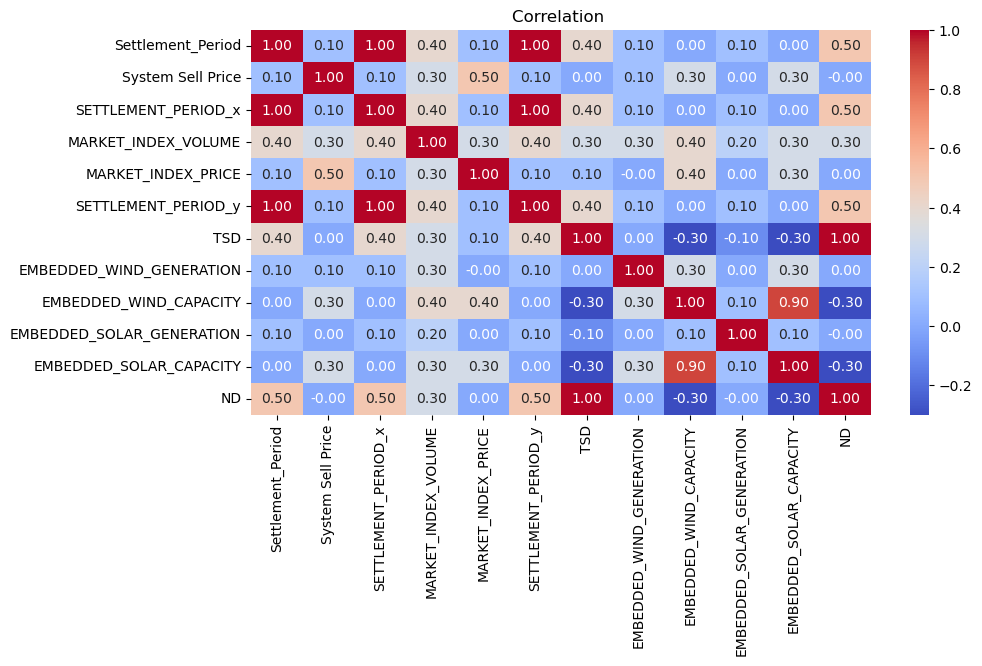

In [56]:
correlation_matrix = predict_final.corr()

#  heatmap correlation
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

In [57]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161737 entries, 0 to 161736
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   DATETIME                   161737 non-null  datetime64[ns]
 1   Settlement_Period          161737 non-null  Int64         
 2   System Sell Price          161737 non-null  float64       
 3   SETTLEMENT_PERIOD_x        161737 non-null  Int64         
 4   MARKET_INDEX_VOLUME        161737 non-null  int64         
 5   MARKET_INDEX_PRICE         161737 non-null  int64         
 6   GAS                        161737 non-null  object        
 7   COAL                       161737 non-null  object        
 8   NUCLEAR                    161737 non-null  object        
 9   WIND                       161737 non-null  object        
 10  HYDRO                      161737 non-null  object        
 11  BIOMASS                    161737 non-null  object  

In [58]:
#converting data type
predict_final['HYDRO_perc']=predict_final['HYDRO_perc'].astype(float)
predict_final['WIND_perc']=predict_final['WIND_perc'].astype(float)
predict_final['SOLAR_perc']=predict_final['SOLAR_perc'].astype(float)

In [59]:
cor_df=predict_final[['MARKET_INDEX_PRICE','MARKET_INDEX_VOLUME','TSD','System Sell Price','EMBEDDED_WIND_GENERATION','EMBEDDED_WIND_CAPACITY','HYDRO_perc','WIND_perc','SOLAR_perc']]

In [61]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161737 entries, 0 to 161736
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   DATETIME                   161737 non-null  datetime64[ns]
 1   Settlement_Period          161737 non-null  Int64         
 2   System Sell Price          161737 non-null  float64       
 3   SETTLEMENT_PERIOD_x        161737 non-null  Int64         
 4   MARKET_INDEX_VOLUME        161737 non-null  int64         
 5   MARKET_INDEX_PRICE         161737 non-null  int64         
 6   GAS                        161737 non-null  object        
 7   COAL                       161737 non-null  object        
 8   NUCLEAR                    161737 non-null  object        
 9   WIND                       161737 non-null  object        
 10  HYDRO                      161737 non-null  object        
 11  BIOMASS                    161737 non-null  object  

In [3]:
# Splitting Independent variable and Dependent variable
y = predict_final['MARKET_INDEX_PRICE'].copy()
X = predict_final[['MARKET_INDEX_VOLUME','TSD','System Sell Price','EMBEDDED_WIND_GENERATION','EMBEDDED_WIND_CAPACITY','HYDRO_perc','WIND_perc','SOLAR_perc']]

## LinearRegression for 2014- 2023

In [64]:
sc = StandardScaler()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [66]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [67]:
mlr = LinearRegression()  
mlr.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred_mlr= mlr.predict(X_test)

In [69]:
r2_lr=r2_score(y_test, y_pred_mlr)
mae_lr= mean_absolute_error(y_test, y_pred_mlr)
mse_lr= mean_squared_error(y_test, y_pred_mlr)
rmse_lr=mean_squared_error(y_test, y_pred_mlr,squared = False)


In [70]:
print("r2 score: %.10f" % r2_score(y_test, y_pred_mlr))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_mlr))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

r2 score: 0.4062657919
explained variance score: 0.4062785331
mae: 29.7774562763
mse: 2839.3704716391
rmse: 53.2857436060


In [71]:
print(r2_lr)

0.40626579192748646


## Random Forest Model Training

In [73]:
# Create the Random Forest regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [74]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [75]:
y_pred_rf = rf_model.predict(X_test)

In [76]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf= mean_absolute_error(y_test, y_pred_rf)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_rf=mean_squared_error(y_test, y_pred_rf,squared = False)

r2_rf = r2_score(y_test, y_pred_rf)

In [77]:
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)
print("Mean Absoult Error:", mae_rf)
print("  r Mean Squared Error:", rmse_rf)

Mean Squared Error: 695.6953898386299
R-squared: 0.8623311089798189
Mean Absoult Error: 11.422826449857796
  r Mean Squared Error: 26.376038175560595


In [78]:
data_rf = y_pred_rf.reshape(-1)

In [79]:
mlr_diff_rf = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_rf})

In [80]:
mlr_diff_rf

,Actual value,Predicted value
130058,76,99.27
13640,36,35.98
49646,96,69.92
25241,37,38.96
76748,50,46.11
...,...,...
87871,75,69.92
60762,33,34.41
4733,38,41.58
43094,45,43.70


## Scatter plot for Random Forest Predection

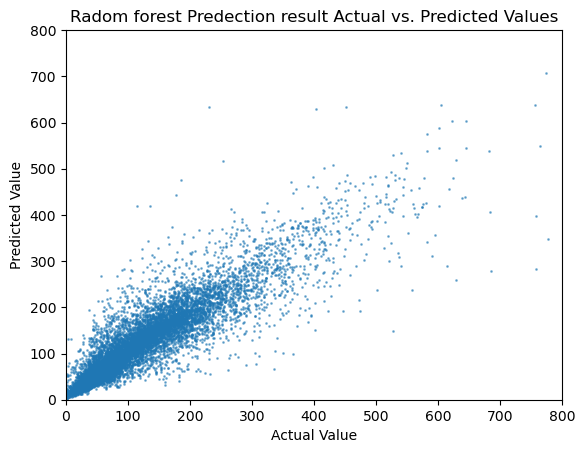

In [82]:
plt.scatter(mlr_diff_rf['Actual value'], mlr_diff_rf['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=800

y_min=0
y_max=800
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Radom forest Predection result Actual vs. Predicted Values')

# Display the plot
plt.show()

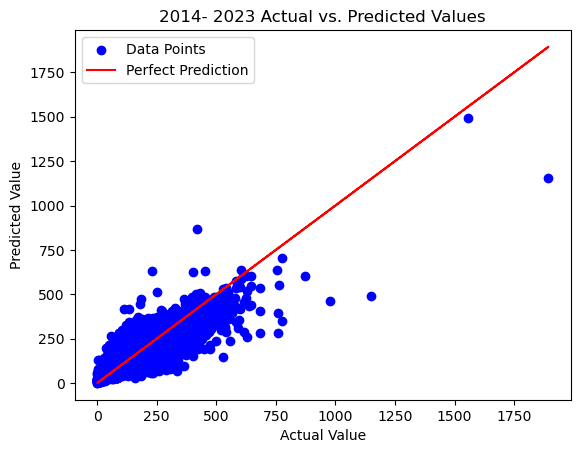

In [135]:
plt.scatter(mlr_diff_rf['Actual value'], mlr_diff_rf['Predicted value'], color='blue', label='Data Points')
plt.plot(mlr_diff_rf['Actual value'], mlr_diff_rf['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014- 2023 Actual vs. Predicted Values')
plt.legend()
plt.show()

## Training Data with ANN Model 2014 - 2023

In [86]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [103]:
model_ann = Sequential()

#input layer
model_ann.add(Dense(units=8, activation='relu', input_shape=(X_train.shape[1],)))

# hidden layers 
model_ann.add(Dense(units=4, activation='relu'))
model_ann.add(Dense(units=4, activation='relu'))
model_ann.add(Dense(units=4, activation='relu'))
#output layer
model_ann.add(Dense(units=1, activation='linear'))

# Compile the model
model_ann.compile(loss='mean_squared_error', optimizer='adam')

## ANN

In [104]:
batch_size = 42
epochs = 20
model_ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
2465/2465 [==============================] - 6s 2ms/step - loss: 249725.3594 - val_loss: 4576.3945
Epoch 2/20
2465/2465 [==============================] - 4s 2ms/step - loss: 4579.1885 - val_loss: 4354.0615
Epoch 3/20
2465/2465 [==============================] - 4s 2ms/step - loss: 4009.0449 - val_loss: 3082.8784
Epoch 4/20
2465/2465 [==============================] - 5s 2ms/step - loss: 2925.3228 - val_loss: 2685.5649
Epoch 5/20
2465/2465 [==============================] - 5s 2ms/step - loss: 2739.9712 - val_loss: 2518.7756
Epoch 6/20
2465/2465 [==============================] - 6s 2ms/step - loss: 2704.7446 - val_loss: 2694.1528
Epoch 7/20
2465/2465 [==============================] - 5s 2ms/step - loss: 2700.5786 - val_loss: 2461.8784
Epoch 8/20
2465/2465 [==============================] - 4s 2ms/step - loss: 2676.8423 - val_loss: 2446.9199
Epoch 9/20
2465/2465 [==============================] - 2s 980us/step - loss: 2648.1709 - val_loss: 2444.2783
Epoch 10/20
2465/2465 [=

In [105]:
y_pred_ann = model_ann.predict(X_test)

print("r2 score: %.10f" % r2_score(y_test, y_pred_ann))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_ann))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_ann))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_ann))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_ann,squared = False))

1011/1011 [==============================] - 1s 564us/step
r2 score: 0.5244226927
explained variance score: 0.5377266792
mae: 27.4850934687
mse: 2403.2803472461
rmse: 49.0232633272


In [106]:
mse_ann = mean_squared_error(y_test, y_pred_ann)
mae_ann= mean_absolute_error(y_test, y_pred_ann)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_ann=mean_squared_error(y_test, y_pred_ann,squared = False)

r2_ann = r2_score(y_test, y_pred_ann)

In [107]:
print("Mean absoult Error:", mae_ann)
print("R-squared:", r2_ann)
print(" R mean square error:", rmse_ann)

Mean absoult Error: 27.485093468742374
R-squared: 0.5244226926777469
 R mean square error: 49.023263327180295


In [109]:
print(" ANN Mean absoult Error:", mae_ann)
print("ANN R-squared:", r2_ann)
print(" ANN R mean square error:", rmse_ann)
print("ANN Mean Squared Error:", mse_rf)
print(" Random forest R-squared:", r2_rf)
print("Random forest Mean Absoult Error:", mae_rf)
print(" Random forest r Mean Squared Error:", rmse_rf)
print("Linear Regression r2 score: %.10f" % r2_score(y_test, y_pred_mlr))

print(" Linear Regression mae : %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("Linear Regression mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("Linear Regression rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

 ANN Mean absoult Error: 27.485093468742374
ANN R-squared: 0.5244226926777469
 ANN R mean square error: 49.023263327180295
ANN Mean Squared Error: 695.6953898386299
 Random forest R-squared: 0.8623311089798189
Random forest Mean Absoult Error: 11.422826449857796
 Random forest r Mean Squared Error: 26.376038175560595
Linear Regression r2 score: -0.3707983696
 Linear Regression mae : 53.0033554244
Linear Regression mse: 6927.1866652855
Linear Regression rmse: 83.2297222468


In [ ]:
plt.scatter(mlr_diff_rf['Actual value'], mlr_diff_rf['Predicted value'], color='blue', label='Data Points')
plt.plot(mlr_diff_rf['Actual value'], mlr_diff_rf['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014- 2019 Actual vs. Predicted Values')
plt.legend()
plt.show()

In [110]:
data_ann = y_pred_ann.reshape(-1)

In [111]:
mlr_diff_ann = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_ann})

In [144]:
mlr_diff_ann['ID'] = mlr_diff_ann.reset_index().index + 1

In [147]:
#mlr_diff_ann.iloc[50:101]

,Actual value,Predicted value,ID
62317,38,55.939510,51
157230,119,86.032684,52
56617,33,45.547253,53
111571,23,30.024569,54
102851,67,73.901749,55
15645,42,51.781528,56
29815,33,34.260967,57
93128,40,51.771534,58
74786,42,84.274261,59
134429,211,132.934036,60


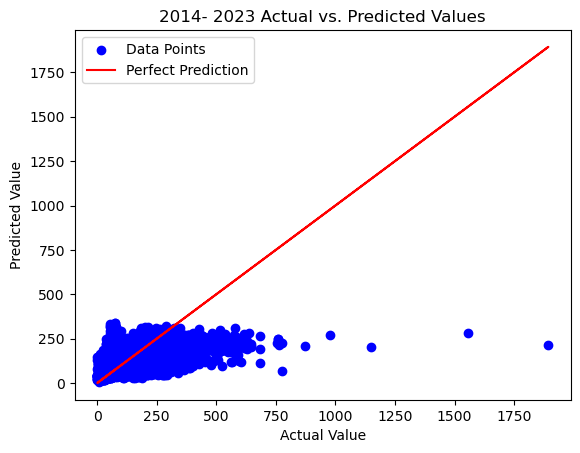

In [118]:
plt.scatter(mlr_diff_ann['Actual value'], mlr_diff_ann['Predicted value'], color='blue', label='Data Points')
plt.plot(mlr_diff_ann['Actual value'], mlr_diff_ann['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014- 2023 Actual vs. Predicted Values')
plt.legend()
plt.show()

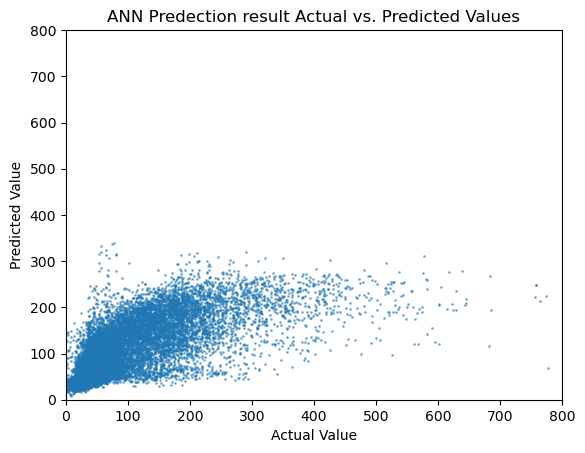

In [119]:
plt.scatter(mlr_diff_ann['Actual value'], mlr_diff_ann['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=800

y_min=0
y_max=800
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('ANN Predection result Actual vs. Predicted Values')

# Display the plot
plt.show()

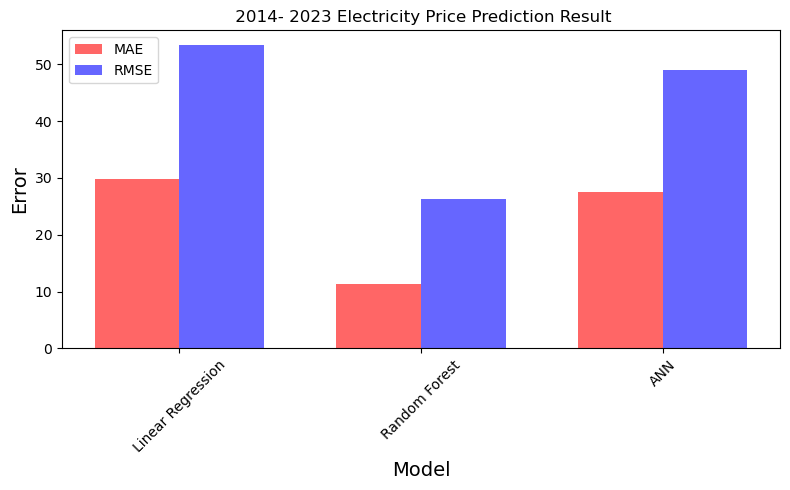

In [133]:
models = ['Linear Regression', 'Random Forest','ANN']
mae_values = [mae_lr, mae_rf, mae_ann]
rmse_values = [rmse_lr, rmse_rf, rmse_ann]
#r2_values = [r2_lr, r2_rf, r2_ann]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(8, 5))
plt.bar(index, mae_values, width=bar_width, label='MAE', color='r', alpha=0.6)
plt.bar(index + bar_width, rmse_values, width=bar_width, label='RMSE', color='b', alpha=0.6)
#plt.bar(index +2* bar_width, r2_values, width=bar_width, label=' R2 Score', color='g', alpha=0.6)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title(' 2014- 2023 Electricity Price Prediction Result', fontsize=12)
plt.xticks(index + bar_width/2, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [134]:
print(" ANN Mean absoult Error:", mae_ann)
print("ANN R-squared:", r2_ann)
print(" ANN R mean square error:", rmse_ann)
print("ANN Mean Squared Error:", mse_rf)
print(" Random forest R-squared:", r2_rf)
print("Random forest Mean Absoult Error:", mae_rf)
print(" Random forest r Mean Squared Error:", rmse_rf)
print("Linear Regression r2 score: %.10f" % r2_score(y_test, y_pred_mlr))

print(" Linear Regression mae : %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("Linear Regression mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("Linear Regression rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

 ANN Mean absoult Error: 27.485093468742374
ANN R-squared: 0.5244226926777469
 ANN R mean square error: 49.023263327180295
ANN Mean Squared Error: 695.6953898386299
 Random forest R-squared: 0.8623311089798189
Random forest Mean Absoult Error: 11.422826449857796
 Random forest r Mean Squared Error: 26.376038175560595
Linear Regression r2 score: -0.3707983696
 Linear Regression mae : 53.0033554244
Linear Regression mse: 6927.1866652855
Linear Regression rmse: 83.2297222468


## Second  try

In [120]:
model_ann2 = Sequential()

# input layer
model_ann2.add(Dense(units=8, activation='relu', input_shape=(X_train.shape[1],)))
#hidden layer
model_ann2.add(Dense(units=4, activation='relu'))
model_ann2.add(Dense(units=4, activation='relu'))
model_ann2.add(Dense(units=4, activation='relu'))
#output layer
model_ann2.add(Dense(units=1, activation='linear'))

# Compile the model
model_ann2.compile(loss='mean_squared_error', optimizer='adam')

In [121]:
batch_size = 42
epochs = 50
model_ann2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
2465/2465 [==============================] - 4s 1ms/step - loss: 22124.9805 - val_loss: 5594.7104
Epoch 2/50
2465/2465 [==============================] - 3s 1ms/step - loss: 6126.3794 - val_loss: 4634.1426
Epoch 3/50
2465/2465 [==============================] - 3s 1ms/step - loss: 5342.7812 - val_loss: 4036.9136
Epoch 4/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4992.1738 - val_loss: 3514.3411
Epoch 5/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4642.9907 - val_loss: 3315.8396
Epoch 6/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4375.7349 - val_loss: 2936.3562
Epoch 7/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4351.4639 - val_loss: 2962.3127
Epoch 8/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4118.4302 - val_loss: 3327.2839
Epoch 9/50
2465/2465 [==============================] - 3s 1ms/step - loss: 4177.9468 - val_loss: 3086.4797
Epoch 10/50
2465/2465 [====

In [122]:
y_pred_ann2 = model_ann2.predict(X_test)

print("r2 score: %.10f" % r2_score(y_test, y_pred_ann2))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_ann2))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_ann2))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_ann2))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_ann2,squared = False))

1011/1011 [==============================] - 1s 574us/step
r2 score: 0.4524701136
explained variance score: 0.4539570794
mae: 27.6325508419
mse: 2766.8852053387
rmse: 52.6011901514


In [123]:
ann_data2 = y_pred_ann2.reshape(-1)

In [124]:
ann_diff2 = pd.DataFrame({'Actual value': y_test, 'Predicted value': ann_data2})

In [125]:
ann_diff2

,Actual value,Predicted value
130058,76,91.397095
13640,36,52.431156
49646,96,52.431156
25241,37,52.431156
76748,50,52.431156
...,...,...
87871,75,60.149487
60762,33,72.443596
4733,38,52.431156
43094,45,52.431156


In [ ]:
plt.scatter(mlr_diff['Actual value'], mlr_diff['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=500

y_min=0
y_max=500
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Actual vs. Predicted Values')

# Display the plot
plt.show()

In [ ]:
import statsmodels.api as sm
sm.qqplot(mlr_diff['Predicted value'], line='s');

In [ ]:
#define residuals
res = mlr_diff.resid

#create Q-Q plot
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 

In [ ]:
plt.scatter(mlr_diff['Actual value'], mlr_diff['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=500

y_min=0
y_max=500
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Actual vs. Predicted Values')

# Display the plot
plt.show()

In [ ]:
models = ['Linear Regression', 'Random Forest','ANN']
mae_values = [mae_lr, mae_rf, mae_ann]
rmse_values = [rmse_lr, rmse_rf, rmse_ann]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(8, 5))
plt.bar(index, mae_values, width=bar_width, label='MAE', color='r', alpha=0.6)
plt.bar(index + bar_width, rmse_values, width=bar_width, label='RMSE', color='b', alpha=0.6)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('MAE vs RMSE for Electricity Price Prediction Result', fontsize=12)
plt.xticks(index + bar_width/2, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()